# Explainable AI with Synthetic Data

Demonstration on how a ML model, that was trained on real data, can be perfectly explored, reasoned around and validated in great detail with synthetic data. As synthetic data is not restricted by privacy, this allows to engage with far broader groups and communities, when it comes to algorithmic auditing, and ensuring the safety of developed ML-powered systems..

## Train ML Model on Real Data

Let's again use the UCI Adult [[1](#refs)] dataset, consisting of 48,842 records across 14 attributes. We will initially remove 4 attributes to make the analysis later on more insightful.

In [ ]:
#!pip install scikit-learn seaborn lightgbm shap

In [ ]:
import pandas as pd
import numpy as np

# fetch original data and drop a couple of variables
df = pd.read_csv('https://github.com/Felix-au/explainable-ai/blob/main/census.csv.gz')
df = df.drop(columns=['fnlwgt', 'education_num', 'race', 'native_country'])
df.head(5)

,age,workclass,education,marital_status,occupation,relationship,sex,capital_gain,capital_loss,hours_per_week,income
0,39,State-gov,Bachelors,Never-married,Adm-clerical,Not-in-family,Male,2174,0,40,<=50K
1,50,Self-emp-not-inc,Bachelors,Married-civ-spouse,Exec-managerial,Husband,Male,0,0,13,<=50K
2,38,Private,HS-grad,Divorced,Handlers-cleaners,Not-in-family,Male,0,0,40,<=50K
3,53,Private,11th,Married-civ-spouse,Handlers-cleaners,Husband,Male,0,0,40,<=50K
4,28,Private,Bachelors,Married-civ-spouse,Prof-specialty,Wife,Female,0,0,40,<=50K


In [ ]:
import lightgbm as lgb
from lightgbm import early_stopping
from sklearn.model_selection import train_test_split

target_col = 'income'
target_val = '>50K'

def prepare_xy(df):
    y = (df[target_col]==target_val).astype(int)
    str_cols = [col for col in df.select_dtypes(['object', 'string']).columns if col != target_col]
    for col in str_cols:
        df[col] = pd.Categorical(df[col])
    cat_cols = [col for col in df.select_dtypes('category').columns if col != target_col]
    num_cols = [col for col in df.select_dtypes('number').columns if col != target_col]
    for col in num_cols:
        df[col] = df[col].astype('float')
    X = df[cat_cols + num_cols]
    return X, y

def train_model(X, y):
    cat_cols = list(X.select_dtypes('category').columns)
    X_trn, X_val, y_trn, y_val = train_test_split(X, y, test_size=0.2, random_state=1)
    ds_trn = lgb.Dataset(X_trn, label=y_trn, categorical_feature=cat_cols, free_raw_data=False)
    ds_val = lgb.Dataset(X_val, label=y_val, categorical_feature=cat_cols, free_raw_data=False)
    model = lgb.train(
        params={
            'verbose': -1,
            'metric': 'auc',
            'objective': 'binary'
        },
        train_set=ds_trn,
        valid_sets=[ds_val],
        callbacks=[early_stopping(5)],
    )
    return model

import warnings
warnings.filterwarnings('ignore')

In [ ]:
X, y = prepare_xy(df)
model = train_model(X, y)

Training until validation scores don't improve for 5 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.92857


## Synthesize Data via MOSTLY AI

The code below will automatically create a synthetic dataset using the Synthetic Data SDK.

In [ ]:
%pip install mostlyai[local]

In [ ]:
from mostlyai.sdk import MostlyAI

# initialize SDK
mostly = MostlyAI(local=True)  # or: MostlyAI(local=False, api_key='xxx')

Initializing Synthetic Data SDK 5.4.2 in LOCAL mode 🏠

Connected to ]8;id=645449;file:///root/mostlyai\/root/]8;;\]8;id=420009;file:///root/mostlyai\mostlyai]8;;\ with 13 GB RAM, 2 CPUs, 0 GPUs available

In [ ]:
# train a generator on the original training data
g = mostly.train(config={
    'name': 'Explainable AI Tutorial Census',
    'tables': [{
        'name': 'data',
        'data': df,
        'tabular_model_configuration': {'max_training_time': 1},
    }]
})

Created generator c7c1d782-dc3a-4edb-8b86-d88c604c9a5e

Started generator training

Output()

🎉 Your generator is ready! Use it to create synthetic data. Publish it so others can do the same.

In [ ]:
# generate a synthetic dataset
syn = mostly.generate(g).data()
print(f"Created synthetic data with {syn.shape[0]:,} records and {syn.shape[1]:,} attributes")

Created synthetic dataset c9e9ff38-85a4-4b4c-abcf-10dcf1cc6947 with generator c7c1d782-dc3a-4edb-8b86-d88c604c9a5e

Started synthetic dataset generation

Output()

🎉 Your synthetic dataset is ready! Use it to consume the generated data. Publish it so others can do the same.

Created synthetic data with 48,842 records and 11 attributes


## Evaluate ML Performance on Synthetic

This is also known as a Train-Real-Test-Synthetic (TRTS) approach.

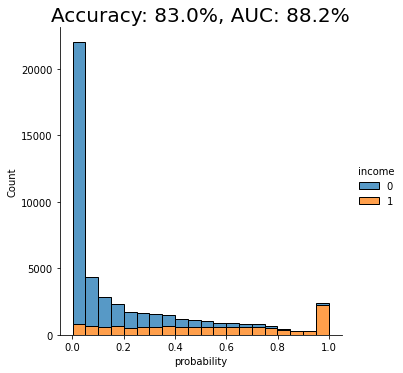

In [ ]:
from sklearn.metrics import roc_auc_score, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 72

X_syn, y_syn = prepare_xy(syn)
p_syn = model.predict(X_syn)
auc = roc_auc_score(y_syn, p_syn)
acc = accuracy_score(y_syn, (p_syn >= 0.5).astype(int))
probs_df = pd.concat([
    pd.Series(p_syn, name='probability').reset_index(drop=True),
    pd.Series(y_syn, name=target_col).reset_index(drop=True),
], axis=1)
fig = sns.displot(data=probs_df, x='probability', hue=target_col, bins=20, multiple="stack")
fig = plt.title(f"Accuracy: {acc:.1%}, AUC: {auc:.1%}", fontsize=20)
plt.show()

## Explain ML Model with Synthetic

We will be using the **SHAP library**, a state-of-the-art Python package for Explainable AI. Learn more about SHAP and XAI at https://shap-lrjball.readthedocs.io/ and https://christophm.github.io/interpretable-ml-book/.

### Calculate SHAP values for trained model w/ synthetic data

Important: For this step no access to the original (privacy-sensitive) training data is needed anymore. We only need access to the trained model for inference, as well as to representative synthetic data.

In [ ]:
import shap
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_syn)

import warnings
warnings.filterwarnings('ignore')

### SHAP Feature Importance

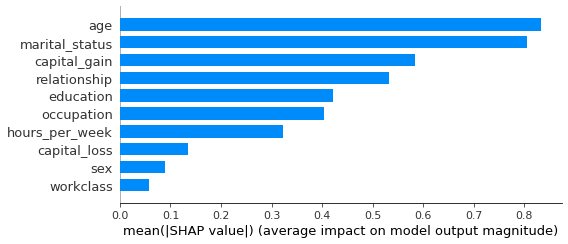

In [ ]:
shap.initjs()
shap.summary_plot(shap_values, X_syn, plot_size=0.2, plot_type='bar')

### SHAP Dependency Plots

Let's study the value-dependent impact of each model feature. SHAP dependency plots are a great way to do so, as they not only show the average lift, but also the level of variance of that lift, at the same time.

In [ ]:
def plot_shap_dependency(col):
    col_idx = [i for i in range(X_syn.shape[1]) if X_syn.columns[i] == col][0]
    # Check if shap_values is 1-dimensional
    if len(shap_values.shape) == 1:
        shp_vals = pd.Series(shap_values, name='shap_value')
    else:
        shp_vals = pd.Series(shap_values[:, col_idx], name='shap_value')

    col_vals = X_syn.iloc[:, col_idx].reset_index(drop=True)
    df = pd.concat([shp_vals, col_vals], axis=1)

    if col_vals.dtype.name != 'category':
        q01 = df[col].quantile(0.01)
        q99 = df[col].quantile(0.99)
        df = df.loc[(df[col] >= q01) & (df[col] <= q99), :]
    else:
        sorted_cats = list(df.groupby(col)['shap_value'].mean().sort_values().index)
        df[col] = df[col].cat.reorder_categories(sorted_cats, ordered=True)

    fig, ax = plt.subplots(figsize=(8, 4))
    plt.ylim(-3.2, 3.2)
    plt.title(col)
    plt.xlabel('')
    if col_vals.dtype.name == 'category':
        plt.xticks(rotation=90)
    ax.tick_params(axis='both', which='major', labelsize=8)
    ax.tick_params(axis='both', which='minor', labelsize=6)
    sns.lineplot(x=df[col], y=df['shap_value'], color='black').axhline(0, color='gray', alpha=1, lw=0.5)
    sns.scatterplot(x=df[col], y=df['shap_value'], alpha=0.1)

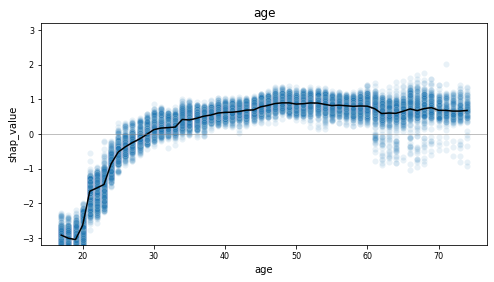

In [ ]:
plot_shap_dependency('age')

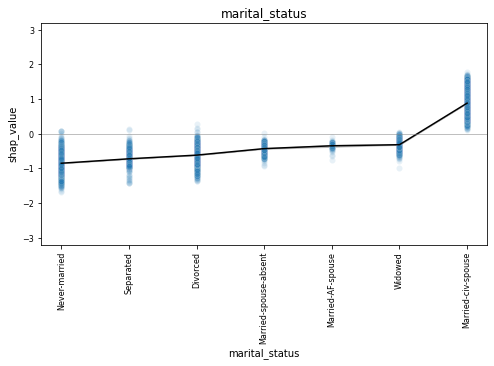

In [ ]:
plot_shap_dependency('marital_status')

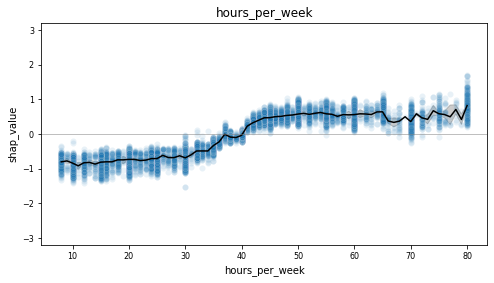

In [ ]:
plot_shap_dependency('hours_per_week')

### SHAP Values for Single (Synthetic) Samples

Let's study the factors behind the model scores by inspecting individual samples. Note, that this level of reasoning at an individual-level would not be possible with real data, if that consists of privacy-sensitive information. However, synthetic data allows to reason around samples at any scale.

In [ ]:
def show_idx(i):
    shap.initjs()
    df = X_syn.iloc[i:i+1, :]
    df.insert(0, 'actual', y_syn.iloc[i])
    df.insert(1, 'score', p_syn[i])
    display(df)

    # Determine the correct expected value and shap values based on the structure of explainer.expected_value
    if isinstance(explainer.expected_value, np.ndarray) and explainer.expected_value.ndim > 0:
        # For multi-class classifiers
        expected_value = explainer.expected_value[1]
        shap_val = shap_values[1][i] if isinstance(shap_values[1], np.ndarray) else shap_values[1]
    else:
        # For binary classifiers or regressors
        expected_value = explainer.expected_value
        shap_val = shap_values[i]

    return shap.force_plot(expected_value, shap_val, X_syn.iloc[i, :], link="logit")

#### Random Sample

In [ ]:
rnd_idx = X_syn.sample().index[0]
show_idx(rnd_idx)

,actual,score,workclass,education,marital_status,occupation,relationship,sex,age,capital_gain,capital_loss,hours_per_week
21482,0,0.007586,Private,11th,Divorced,Machine-op-inspct,Not-in-family,Male,33.0,0.0,0.0,40.0


#### Sample with lowest score

In [ ]:
idx = np.argsort(p_syn)[0]
show_idx(idx)

,actual,score,workclass,education,marital_status,occupation,relationship,sex,age,capital_gain,capital_loss,hours_per_week
6625,0,0.000156,Private,11th,Never-married,Other-service,Own-child,Female,17.0,600.0,0.0,3.0


#### Sample with highest score

In [ ]:
idx = np.argsort(p_syn)[-1]
show_idx(idx)

,actual,score,workclass,education,marital_status,occupation,relationship,sex,age,capital_gain,capital_loss,hours_per_week
30484,1,0.999766,Self-emp-inc,Assoc-voc,Divorced,Machine-op-inspct,Not-in-family,Male,31.0,14059.0,1565.0,40.0


#### Sample with a median score

In [ ]:
idx = np.argsort(p_syn)[int(len(p_syn)/2)]
show_idx(idx)

,actual,score,workclass,education,marital_status,occupation,relationship,sex,age,capital_gain,capital_loss,hours_per_week
240,0,0.073185,Private,HS-grad,Divorced,Transport-moving,Unmarried,Male,56.0,0.0,0.0,40.0


#### Sample a young Female Doctor

In [ ]:
idx = syn[(syn.education=='Doctorate') & (syn.sex=='Female') & (syn.age<=30)].sample().index[0]
show_idx(idx)

,actual,score,workclass,education,marital_status,occupation,relationship,sex,age,capital_gain,capital_loss,hours_per_week
33735,0,0.027785,Private,Doctorate,Never-married,Prof-specialty,Not-in-family,Female,28.0,0.0,0.0,30.0


### Explore SHAP Values across a thousand samples

In [ ]:
shap.initjs()

# Determine the correct expected value
if isinstance(explainer.expected_value, np.ndarray):
    expected_value = explainer.expected_value[1]
else:
    expected_value = explainer.expected_value

# Adjust how you access shap_values based on its structure
if isinstance(shap_values, list) and len(shap_values) > 1:
    shap_vals_subset = shap_values[1][:1000, :]
else:
    shap_vals_subset = shap_values[:1000, :]

shap.force_plot(expected_value, shap_vals_subset, X.iloc[:1000, :], link="logit")

## References<a class="anchor" name="refs"></a>

1. https://archive.ics.uci.edu/ml/datasets/adult